In [40]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from gensim.models import Word2Vec


In [41]:
# Cargar dataset de ejemplo (ajustar según el dataset real)
df = pd.read_csv('movie_data.csv')  # Asegúrate de reemplazar con tu archivo real
df = df[['review', 'sentiment']]  # Suponiendo que "review" es el texto y "label" es la categoría


In [42]:
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Función de limpieza de texto
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\W', ' ', text)  # Quitar caracteres especiales
    text = re.sub(r'\s+', ' ', text).strip()  # Quitar espacios extra
    text = ' '.join(word for word in text.split() if word not in stop_words)  # Quitar stopwords
    return text

df['processed_review'] = df['review'].apply(preprocess_text)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\velez\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [43]:
vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = vectorizer.fit_transform(df['processed_review']).toarray()
y = df['sentiment'].values

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

In [45]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Convertir a tensores
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1).to(device)

In [46]:
class NNBPClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(NNBPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

# Inicializar modelo
hidden_dim = 64
model = NNBPClassifier(X_train.shape[1], hidden_dim).to(device)

In [47]:
class NNBPClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(NNBPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

# Inicializar modelo
hidden_dim = 64
model = NNBPClassifier(X_train.shape[1], hidden_dim).to(device)

In [48]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 10
for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

Epoch [1/10], Loss: 0.6934
Epoch [2/10], Loss: 0.6918
Epoch [3/10], Loss: 0.6900
Epoch [4/10], Loss: 0.6877
Epoch [5/10], Loss: 0.6852
Epoch [6/10], Loss: 0.6825
Epoch [7/10], Loss: 0.6798
Epoch [8/10], Loss: 0.6771
Epoch [9/10], Loss: 0.6743
Epoch [10/10], Loss: 0.6714


In [49]:
# Tokenizar los textos ya preprocesados
tokenized_reviews = [text.split() for text in df['processed_review']]

# Entrenar modelo Word2Vec con Skip-Gram
w2v_model = Word2Vec(sentences=tokenized_reviews, vector_size=100, window=5, sg=1, min_count=2, workers=4)

# Obtener embeddings para cada palabra
word_vectors = w2v_model.wv

# Verificar tamaño del vocabulario de Word2Vec
print(f'Vocabulario de Word2Vec: {len(word_vectors)} palabras')

Vocabulario de Word2Vec: 62968 palabras


In [50]:
# Función para obtener embeddings promedio por documento
def document_vector(tokens, model):
    vectors = [model[word] for word in tokens if word in model]
    return np.mean(vectors, axis=0) if vectors else np.zeros(model.vector_size)

# Convertir cada review a su vector promedio
X_w2v = np.array([document_vector(tokens, word_vectors) for tokens in tokenized_reviews])

# Dividir en entrenamiento y prueba
X_train_w2v, X_test_w2v, y_train_w2v, y_test_w2v = train_test_split(X_w2v, y, test_size=0.2, random_state=42)

# Convertir a tensores
X_train_w2v_tensor = torch.tensor(X_train_w2v, dtype=torch.float32).to(device)
X_test_w2v_tensor = torch.tensor(X_test_w2v, dtype=torch.float32).to(device)
y_train_w2v_tensor = torch.tensor(y_train_w2v, dtype=torch.float32).view(-1, 1).to(device)
y_test_w2v_tensor = torch.tensor(y_test_w2v, dtype=torch.float32).view(-1, 1).to(device)

In [51]:
# Inicializar nuevo modelo NNBP para Word2Vec
model_w2v = NNBPClassifier(X_train_w2v.shape[1], hidden_dim).to(device)

# Definir función de pérdida y optimizador
criterion = nn.BCELoss()
optimizer = optim.Adam(model_w2v.parameters(), lr=0.001)

# Entrenar modelo con Word2Vec
epochs = 10
for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model_w2v(X_train_w2v_tensor)
    loss = criterion(outputs, y_train_w2v_tensor)
    loss.backward()
    optimizer.step()
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

Epoch [1/10], Loss: 0.6934
Epoch [2/10], Loss: 0.6919
Epoch [3/10], Loss: 0.6906
Epoch [4/10], Loss: 0.6894
Epoch [5/10], Loss: 0.6884
Epoch [6/10], Loss: 0.6874
Epoch [7/10], Loss: 0.6865
Epoch [8/10], Loss: 0.6856
Epoch [9/10], Loss: 0.6848
Epoch [10/10], Loss: 0.6839


In [52]:
# Evaluar modelo con Word2Vec
with torch.no_grad():
    y_pred_w2v = model_w2v(X_test_w2v_tensor)
    y_pred_w2v_labels = (y_pred_w2v >= 0.5).float()
    accuracy_w2v = accuracy_score(y_test_w2v_tensor.cpu(), y_pred_w2v_labels.cpu())

print(f'Accuracy (NNBP con Word2Vec): {accuracy_w2v:.4f}')
print(classification_report(y_test_w2v_tensor.cpu(), y_pred_w2v_labels.cpu()))

Accuracy (NNBP con Word2Vec): 0.6304
              precision    recall  f1-score   support

         0.0       0.58      0.97      0.72      5034
         1.0       0.89      0.29      0.44      4966

    accuracy                           0.63     10000
   macro avg       0.74      0.63      0.58     10000
weighted avg       0.73      0.63      0.58     10000



In [53]:
with torch.no_grad():
    y_pred_tfidf = model(X_test_tensor)
    y_pred_tfidf_labels = (y_pred_tfidf >= 0.5).float()
    accuracy_tfidf = accuracy_score(y_test_tensor.cpu(), y_pred_tfidf_labels.cpu())

print(f'Accuracy con TF-IDF: {accuracy_tfidf:.4f}')


Accuracy con TF-IDF: 0.7987


Accuracy con TF-IDF: 0.7987
Accuracy con Word2Vec: 0.6304


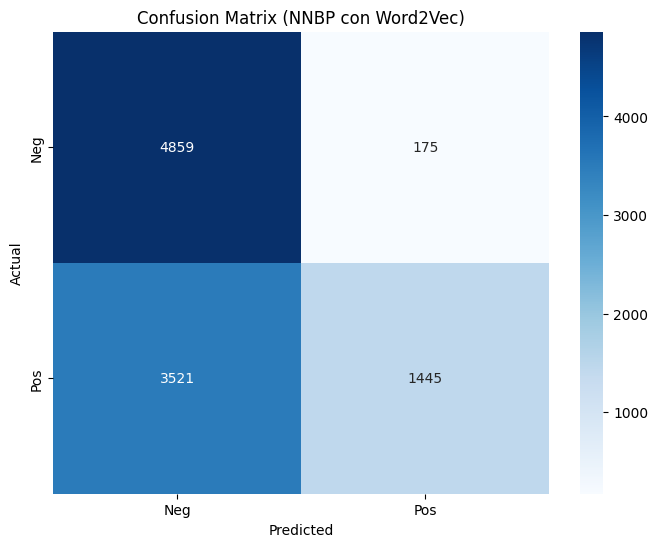

In [54]:
# Comparar Accuracy
print(f'Accuracy con TF-IDF: {accuracy_tfidf:.4f}')
print(f'Accuracy con Word2Vec: {accuracy_w2v:.4f}')

# Comparar Matriz de Confusión
cm_w2v = confusion_matrix(y_test_w2v_tensor.cpu(), y_pred_w2v_labels.cpu())

plt.figure(figsize=(8, 6))
sns.heatmap(cm_w2v, annot=True, fmt='d', cmap='Blues', xticklabels=['Neg', 'Pos'], yticklabels=['Neg', 'Pos'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (NNBP con Word2Vec)')
plt.show()